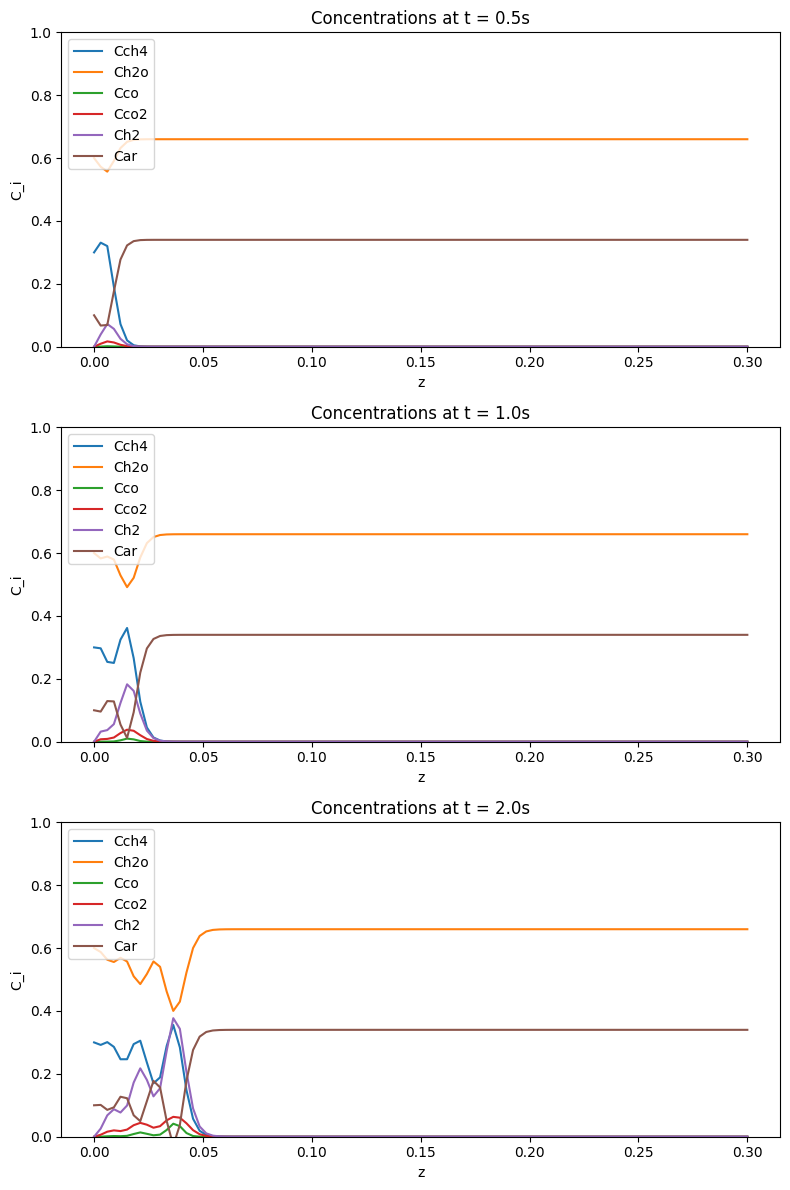

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def rxneq(C, Keq, T):
  gasconstant = 8.314 #J / mol·K
  Easmr = 165.740 #kJ/mol
  Asmr = 1.68 * 10**8
  Eawgs = 100 # kJ/mol
  Awgs = 10**10

  #calculate Kmu still
  Am = 0.03/10**-1
  Mc = 1
  PR = 1
  Psc = 1
  L = 0.3 #m
  Ku = (Am * Mc * PR) / (Psc * L)
  
  I = 9; #Curent in Amp
  F = 96485; #faradays constant in C/mol

  R = np.zeros(3)
  R[0] = Ku * Asmr * np.exp(-Easmr * 1000 / (gasconstant * T)) * (C[0] * C[1] - C[2] * C[3]**3 / Keq[0])
  R[1] = Ku * Awgs * np.exp(-Eawgs * 1000/ (gasconstant * T))*(C[2] * C[1] - C[3] * C[4] / Keq[1])
  R[2] = I / (2 * F)
  return R

def fcalc(C, dz, v0, Keq, T, nu):
  f = np.zeros_like(C)
  for i in range(1, C.shape[1]):
    ych40 = C[0,0] / np.sum(C[:,0])
    X = 1 - (1 + 2 * ych40) / (1 + 2 * ych40 * C[0,i] / C[0,0])
    v = v0 * (1 + 2 * ych40 * X)
    Rmatrix = rxneq(C[:,i], Keq, T)
    for k in range(6):
      if i == C.shape[1] - 1:
        f[k, i] = -v * (C[k, i] - C[k, i-1]) / (2 * dz) + np.dot(nu[k, :], Rmatrix)
      else:
        f[k, i] = -v * (C[k, i+1] - C[k, i-1]) / (2 * dz) + np.dot(nu[k, :], Rmatrix)
  return f

# Constants
P = 3 #atm
T = 1000  # K
u0 = 79.64 * 273 / T * P / 1 / 60 #cm^3/sec
A = np.pi * (3.5/10)**2 #cm^2. I assumed a 7 mm diameter
v0 = u0 / A / 100 #m/sec
Keq = np.array([101325**2 * np.exp(-26830/T + 30.114), np.exp(4400/T - 4.036)])

L = 0.3 #m

# Boundary & Initial Conditions
Cl1 = np.array([0.3, 0.6, 0, 0, 0, 0.1])
C0i = np.array([0, 0.66, 0, 0, 0, 0.34])

# Stoichiometry Matrix
nu = np.array([[-1, 0, 0], [-1, -1, 0], [1, -1, 0], [0, 1, 0], [3, 1, 1], [0, 0, 0]])

# Integration Steps
N = 100
dt = 0.00001
numsteps = 2 * 10**5
dz = L / (N - 1)
z = np.linspace(0, 1, N)*L

# Initialize Concentration Matrix
C = np.tile(C0i[:, np.newaxis], (1, N))
C[:, 0] = Cl1

# Integration Loop
plot0 = C.copy()
plota, plotb, plotc = None, None, None

for l in np.arange(dt, dt * numsteps + dt, dt):
  C  += dt * fcalc(C, dz, v0, Keq, T, nu)
  if numsteps / 4 * dt == l:
    plota = C.copy()
  elif l == numsteps/2 * dt:
    plotb = C.copy()
plotc = C.copy()

# Plot Results
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

def plot_data(ax, data, title, time):
  ax.plot(z, data[0,:], label='Cch4')
  ax.plot(z, data[1,:], label='Ch2o')
  ax.plot(z, data[2,:], label='Cco')
  ax.plot(z, data[3,:], label='Cco2')
  ax.plot(z, data[4,:], label='Ch2')
  ax.plot(z, data[5,:], label='Car')
  ax.set_ylim([0, 1])
  ax.set_xlabel('z')
  ax.set_ylabel('C_i')
  ax.set_title(f'Concentrations at t = {time}s')
  ax.legend()

plot_data(axs[0], plota, 'Concentration', (numsteps / 4 * dt))
plot_data(axs[1], plotb, 'Concentration', (numsteps/2 * dt))
plot_data(axs[2], plotc, 'Concentration', (numsteps * dt))

plt.tight_layout()
plt.show()

In [ ]:
def Keqcalc(T):
  R = 8.314  # J / mol·K

  #CO2; CO; CH4; H2O; H2 = 00000
  G_const = np.array([
    [-393.4685065, -0.003212871, 1.53E-07, 9.97E-10, -3.31E-13],
    [-110.7347984, -0.086473798, -9.63E-06, 8.56E-09, -2.11E-12],
    [-68.77179183, 0.038329957, 9.22E-05, -5.46E-08, 1.24E-11],
    [-240.6171143, 0.035116356, 2.02E-05, -9.33E-09, 1.78E-12]
  ])
  Gf = np.sum(G_const * np.array([1, T, T**2, T**3, T**4]), axis=1)
  Keqsmr = np.exp(-(Gf[1] - Gf[2] - Gf[3]) * 1000 / (R * T))
  Keqwgs = np.exp(-(Gf[0] - Gf[1] - Gf[3]) * 1000 / (R * T))
  return np.array([Keqsmr, Keqwgs])